## Sử dụng GPU để huấn luyện MLP trên bộ dữ liệu MNIST

In [1]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

train_dataset = datasets.MNIST(
    root="./mnist", train=True, transform=transforms.ToTensor(), download=True
)

test_dataset = datasets.MNIST(
    root="./mnist", train=False, transform=transforms.ToTensor()
)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:13<00:00, 727713.02it/s] 


Extracting ./mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 109110.51it/s]


Extracting ./mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:02<00:00, 661726.55it/s]


Extracting ./mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 1168457.36it/s]

Extracting ./mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist/MNIST/raw



In [2]:
import torch
from torch.utils.data.dataset import random_split

torch.manual_seed(1)
train_dataset, val_dataset = random_split(train_dataset, lengths=[55000, 5000])

In [3]:
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=128,
    shuffle=True,
    num_workers=2,
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=128,
    shuffle=False,
    num_workers=2,
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=128,
    shuffle=False,
    num_workers=2,
)

In [4]:
from collections import Counter

train_counter = Counter()
for images, labels in train_loader:
    train_counter.update(labels.tolist())

print("\nTraining label distribution:")
print(sorted(train_counter.items()))


val_counter = Counter()
for images, labels in val_loader:
    val_counter.update(labels.tolist())

print("\nValidation label distribution:")
print(sorted(val_counter.items()))


test_counter = Counter()
for images, labels in test_loader:
    test_counter.update(labels.tolist())

print("\nTest label distribution:")
print(sorted(test_counter.items()))


Training label distribution:
[(0, 5419), (1, 6185), (2, 5477), (3, 5681), (4, 5349), (5, 4974), (6, 5422), (7, 5710), (8, 5351), (9, 5432)]

Validation label distribution:
[(0, 504), (1, 557), (2, 481), (3, 450), (4, 493), (5, 447), (6, 496), (7, 555), (8, 500), (9, 517)]

Test label distribution:
[(0, 980), (1, 1135), (2, 1032), (3, 1010), (4, 982), (5, 892), (6, 958), (7, 1028), (8, 974), (9, 1009)]


In [5]:
majority_class = test_counter.most_common(1)[0]
print("Majority class:", majority_class[0])

baseline_acc = majority_class[1] / sum(test_counter.values())
print("Accuracy when always predicting the majority class:")
print(f"{baseline_acc:.2f} ({baseline_acc*100:.2f}%)")

Majority class: 1
Accuracy when always predicting the majority class:
0.11 (11.35%)


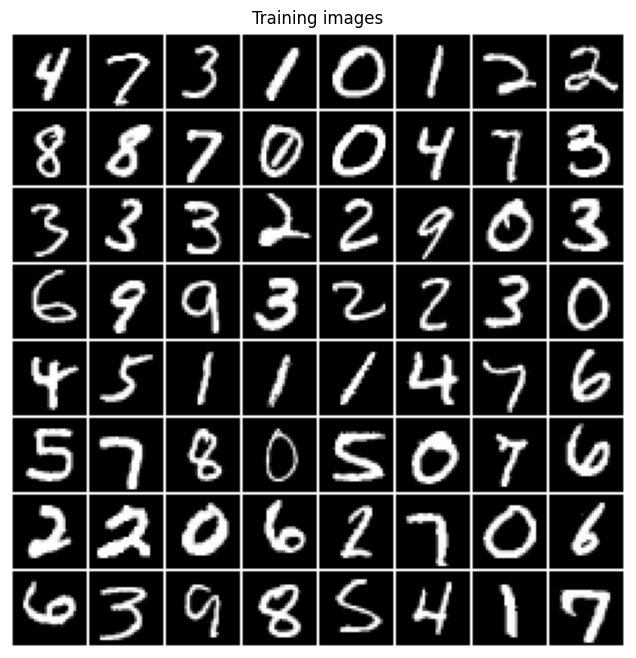

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torchvision


for images, labels in train_loader:
    break

plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training images")
plt.imshow(np.transpose(torchvision.utils.make_grid(
    images[:64],
    padding=1,
    pad_value=1.0,
    normalize=True),
    (1, 2, 0)))
plt.show()

In [7]:
images.shape # batchsize, channel, height, width

torch.Size([128, 1, 28, 28])

In [8]:
class PyTorchMLP(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super().__init__()

        self.all_layers = torch.nn.Sequential(
            # 1st hidden layer
            torch.nn.Linear(num_features, 50),
            torch.nn.ReLU(),
            # 2nd hidden layer
            torch.nn.Linear(50, 25),
            torch.nn.ReLU(),
            # output layer
            torch.nn.Linear(25, num_classes),
        )

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        logits = self.all_layers(x)
        return logits

## Kiểm tra tồn tại GPU

In [9]:
if (torch.cuda.is_available()):
  print("Ton tai GPU cua NVIDIA")
  device = 'cuda'
else:
  device = 'cpu'

In [10]:
def compute_accuracy(model, dataloader):

    model = model.eval()

    correct = 0.0
    total_examples = 0

    for idx, (features, labels) in enumerate(dataloader):
        features = features.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            logits = model(features)

        predictions = torch.argmax(logits, dim=1)

        compare = labels == predictions
        correct += torch.sum(compare)
        total_examples += len(compare)

    return correct / total_examples

In [11]:
import torch.nn.functional as F

torch.manual_seed(1)
model = PyTorchMLP(num_features=784, num_classes=10)
model.to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=0.05)

num_epochs = 10

loss_list = []
train_acc_list, val_acc_list = [], []
for epoch in range(num_epochs):

    model = model.train()
    for batch_idx, (features, labels) in enumerate(train_loader):
        features = features.to(device)
        labels = labels.to(device)
        logits = model(features)

        loss = F.cross_entropy(logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if not batch_idx % 250:
            ### LOGGING
            print(
                f"Epoch: {epoch+1:03d}/{num_epochs:03d}"
                f" | Batch {batch_idx:03d}/{len(train_loader):03d}"
                f" | Train Loss: {loss:.2f}"
            )
        loss_list.append(loss.item())

    train_acc = compute_accuracy(model, train_loader)
    val_acc = compute_accuracy(model, val_loader)
    print(f"Train Acc {train_acc*100:.2f}% | Val Acc {val_acc*100:.2f}%")
    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)

Epoch: 001/010 | Batch 000/430 | Train Loss: 2.33
Epoch: 001/010 | Batch 250/430 | Train Loss: 0.69
Train Acc 87.25% | Val Acc 87.16%
Epoch: 002/010 | Batch 000/430 | Train Loss: 0.37
Epoch: 002/010 | Batch 250/430 | Train Loss: 0.43
Train Acc 90.00% | Val Acc 89.70%
Epoch: 003/010 | Batch 000/430 | Train Loss: 0.35
Epoch: 003/010 | Batch 250/430 | Train Loss: 0.30
Train Acc 91.53% | Val Acc 91.28%
Epoch: 004/010 | Batch 000/430 | Train Loss: 0.24
Epoch: 004/010 | Batch 250/430 | Train Loss: 0.41
Train Acc 92.53% | Val Acc 92.14%
Epoch: 005/010 | Batch 000/430 | Train Loss: 0.17
Epoch: 005/010 | Batch 250/430 | Train Loss: 0.16
Train Acc 93.35% | Val Acc 92.76%
Epoch: 006/010 | Batch 000/430 | Train Loss: 0.22
Epoch: 006/010 | Batch 250/430 | Train Loss: 0.22
Train Acc 94.01% | Val Acc 92.98%
Epoch: 007/010 | Batch 000/430 | Train Loss: 0.14
Epoch: 007/010 | Batch 250/430 | Train Loss: 0.22
Train Acc 94.30% | Val Acc 93.34%
Epoch: 008/010 | Batch 000/430 | Train Loss: 0.15
Epoch: 008/0

In [12]:
train_acc = compute_accuracy(model, train_loader)
val_acc = compute_accuracy(model, val_loader)
test_acc = compute_accuracy(model, test_loader)

print(f"Train Acc {train_acc*100:.2f}%")
print(f"Val Acc {val_acc*100:.2f}%")
print(f"Test Acc {test_acc*100:.2f}%")

Train Acc 95.70%
Val Acc 94.44%
Test Acc 95.27%


## helpler function

In [13]:
import os

import matplotlib.pyplot as plt
import numpy as np
import torch


def plot_training_loss(
    minibatch_loss_list,
    num_epochs,
    iter_per_epoch,
    results_dir=None,
    averaging_iterations=100,
):

    plt.figure()
    ax1 = plt.subplot(1, 1, 1)
    ax1.plot(
        range(len(minibatch_loss_list)), (minibatch_loss_list), label="Minibatch Loss"
    )

    if len(minibatch_loss_list) > 1000:
        ax1.set_ylim([0, np.max(minibatch_loss_list[1000:]) * 1.5])
    ax1.set_xlabel("Iterations")
    ax1.set_ylabel("Loss")

    ax1.plot(
        np.convolve(
            minibatch_loss_list,
            np.ones(
                averaging_iterations,
            )
            / averaging_iterations,
            mode="valid",
        ),
        label="Running Average",
    )
    ax1.legend()

    ###################
    # Set scond x-axis
    ax2 = ax1.twiny()
    newlabel = list(range(num_epochs + 1))

    newpos = [e * iter_per_epoch for e in newlabel]

    ax2.set_xticks(newpos[::10])
    ax2.set_xticklabels(newlabel[::10])

    ax2.xaxis.set_ticks_position("bottom")
    ax2.xaxis.set_label_position("bottom")
    ax2.spines["bottom"].set_position(("outward", 45))
    ax2.set_xlabel("Epochs")
    ax2.set_xlim(ax1.get_xlim())
    ###################

    plt.tight_layout()

    if results_dir is not None:
        image_path = os.path.join(results_dir, "plot_training_loss.pdf")
        plt.savefig(image_path)


def plot_accuracy(train_acc_list, valid_acc_list, results_dir=None):

    num_epochs = len(train_acc_list)

    plt.plot(np.arange(1, num_epochs + 1), train_acc_list, label="Training")
    plt.plot(np.arange(1, num_epochs + 1), valid_acc_list, label="Validation")

    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()

    if results_dir is not None:
        image_path = os.path.join(results_dir, "plot_acc_training_validation.pdf")
        plt.savefig(image_path)


def show_examples(model, data_loader, unnormalizer=None, class_dict=None):

    fail_features, fail_targets, fail_predicted = [], [], []
    for batch_idx, (features, targets) in enumerate(data_loader):

        with torch.no_grad():
            logits = model(features)
            predictions = torch.argmax(logits, dim=1)

            mask = targets != predictions

            fail_features.extend(features[mask])
            fail_targets.extend(targets[mask])
            fail_predicted.extend(predictions[mask])

        if len(fail_targets) > 15:
            break

    fail_features = torch.cat(fail_features)
    fail_targets = torch.tensor(fail_targets)
    fail_predicted = torch.tensor(fail_predicted)

    fig, axes = plt.subplots(nrows=3, ncols=5, sharex=True, sharey=True)

    if unnormalizer is not None:
        for idx in range(fail_features.shape[0]):
            features[idx] = unnormalizer(fail_features[idx])

    if fail_features.ndim == 4:
        nhwc_img = np.transpose(fail_features, axes=(0, 2, 3, 1))
        nhw_img = np.squeeze(nhwc_img.numpy(), axis=3)

        for idx, ax in enumerate(axes.ravel()):
            ax.imshow(nhw_img[idx], cmap="binary")
            if class_dict is not None:
                ax.title.set_text(
                    f"P: {class_dict[fail_predicted[idx].item()]}"
                    f"\nT: {class_dict[fail_targets[idx].item()]}"
                )
            else:
                ax.title.set_text(f"P: {fail_predicted[idx]} | T: {fail_targets[idx]}")
            ax.axison = False

    else:

        for idx, ax in enumerate(axes.ravel()):
            ax.imshow(fail_features[idx], cmap="binary")
            if class_dict is not None:
                ax.title.set_text(
                    f"P: {class_dict[fail_predicted[idx].item()]}"
                    f"\nT: {class_dict[fail_targets[idx].item()]}"
                )
            else:
                ax.title.set_text(f"P: {fail_predicted[idx]} | T: {targets[idx]}")
            ax.axison = False
    plt.tight_layout()
    plt.show()


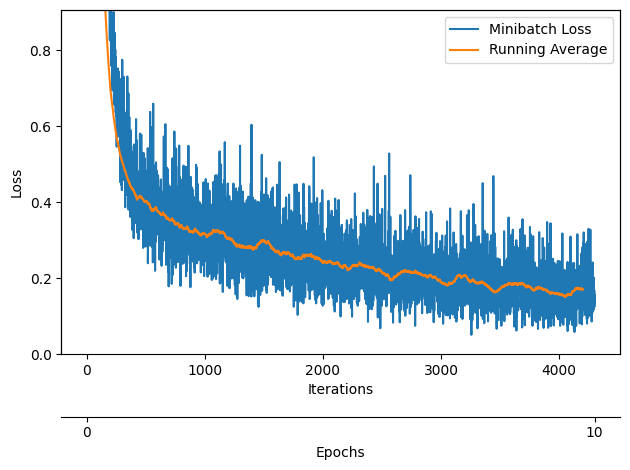

In [14]:
plot_training_loss(minibatch_loss_list=loss_list,
                   num_epochs=num_epochs,
                   iter_per_epoch=len(loss_list)//num_epochs)

[tensor(0.8716), tensor(0.8970), tensor(0.9128), tensor(0.9214), tensor(0.9276), tensor(0.9298), tensor(0.9334), tensor(0.9344), tensor(0.9406), tensor(0.9444)]


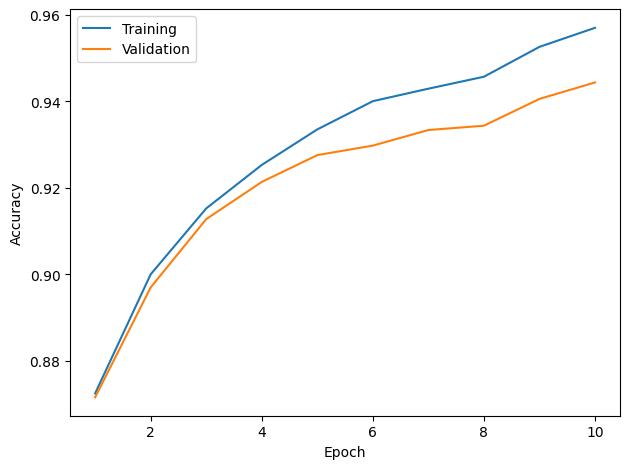

In [15]:
train_acc_list_cpu = [i.to('cpu') for i in train_acc_list]
valid_acc_list_cpu = [i.to('cpu') for i in val_acc_list]
print(valid_acc_list_cpu)
plot_accuracy(train_acc_list=train_acc_list_cpu, valid_acc_list=valid_acc_list_cpu)

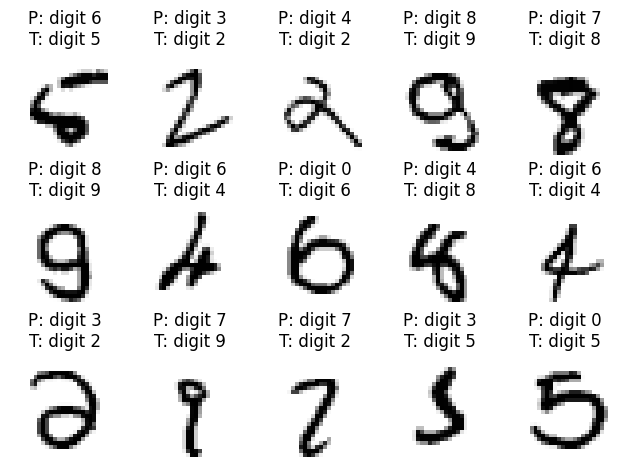

In [16]:
class_dict = {0: 'digit 0',
              1: 'digit 1',
              2: 'digit 2',
              3: 'digit 3',
              4: 'digit 4',
              5: 'digit 5',
              6: 'digit 6',
              7: 'digit 7',
              8: 'digit 8',
              9: 'digit 9'}

show_examples(
    model=model.to('cpu'), data_loader=test_loader, class_dict=class_dict
)